## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, word_split, normalize_to_ascii

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [2]:
tokenizer = pkl.load(open("tokenizer_CNN8000_lowercase.pkl", 'rb'))
tokenizer.create_hash()

random.seed(42)
corpus_indicies = pkl.load(open('corpus/CNN_tokenized8000_lowercase.pkl', 'rb'))
random.shuffle(corpus_indicies)

## Define Model

In [3]:
class WarmUpThenDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
                 initial_learning_rate: float,
                 warmup_steps: int,
                 decay_schedule_fn: tf.keras.optimizers.schedules.LearningRateSchedule):
        """
        initial_learning_rate: peak LR reached at end of warmup
        warmup_steps:      # of steps to ramp from 0 → initial_learning_rate
        decay_schedule_fn: a tf.keras schedule to apply *after* warmup
        """
        super().__init__()
        self.initial_lr = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_schedule_fn = decay_schedule_fn

    def __call__(self, step):
        # Cast to float32 for safety in graph mode
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        # compute linear warmup: lr = initial_lr * (step / warmup_steps)
        warmup_lr = self.initial_lr * (step / warmup_steps)

        # after warmup_steps, switch to decay schedule (shift step count)
        decay_step = step - warmup_steps
        decay_lr = self.decay_schedule_fn(decay_step)

        # if step < warmup_steps, pick warmup_lr, else decay_lr
        return tf.cond(step < warmup_steps,
                       lambda: warmup_lr,
                       lambda: decay_lr)

In [25]:
initial_lr = 1e-4
decay_steps = 25000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 10000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 256
embed_dim = 1024
tf_blocks = 6
heads = 8
ff_dim = 4096

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    lr=lr_schedule,
                    wd = 0.01,
                    )

losses_train = []
losses_test = []


In [26]:
ckpt = tf.train.Checkpoint(
    optimizer=model.optimizer,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/model_8k_tokens_lowercase",      # folder where ckpts are saved
    max_to_keep=5                  # only keep 5 latest checkpoints
)


In [27]:
ckpt.restore(ckpt_manager.latest_checkpoint)

In [28]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 92346244


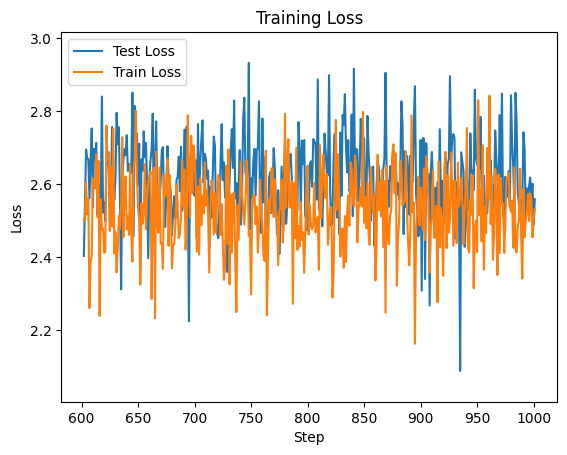

KeyboardInterrupt: 

In [29]:
batch_size = 8
for i in tqdm(range(100000)):
    indices, y_true = sample_batch(corpus_indicies[:22500], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    
    loss_train = model.train_step(indices, y_true)
    losses_train.append(loss_train)

    indices, y_true = sample_batch(corpus_indicies[22500:], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    loss_test = model.evaluate(indices, y_true)
    losses_test.append(loss_test)

    if (i+1) % 1000 == 0:
        ckpt_manager.save()

    clear_output(wait=True)
    x = np.arange(max(0, len(losses_train)-400), len(losses_train))
    plt.plot(x, losses_test[-400:], label="Test Loss")
    plt.plot(x, losses_train[-400:], label="Train Loss")
    

    Min = np.min(losses_train[-400:] + losses_test[-400:])
    Max = np.max(losses_train[-400:]+ losses_test[-400:])
    delta = Max - Min
    plt.ylim(Min - delta*0.1, Max + delta*0.1)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


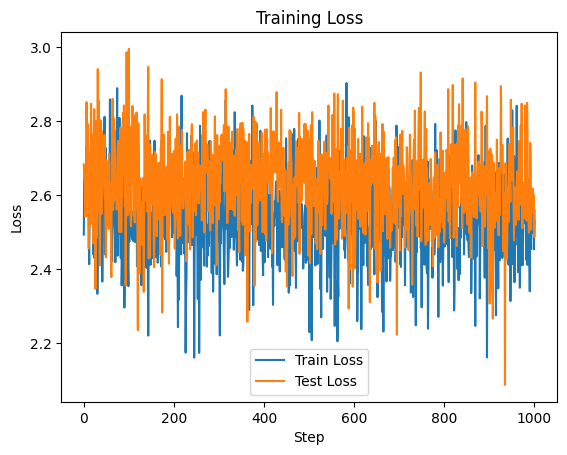

In [37]:
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_test, label="Test Loss")
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
def tokenize(indices, merge_list):
    indices = np.array(indices)
    for pair, new_idx in merge_list:
        slice = np.where(np.logical_and(indices[:-1] == pair[0],  indices[1:] == pair[1]))
        if len(slice[0]) > 0:
            indices[:-1][slice] = new_idx
            indices = np.delete(indices, (slice[0]+1))

    return tf.expand_dims(tf.convert_to_tensor(indices, dtype=tf.int32), axis=0)

In [34]:
text = "Obama's"
text = text.lower()

indices = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices = tokenize(indices, tokenizer.merge_list)
print(indices)

tf.Tensor([[2318]], shape=(1, 1), dtype=int32)


In [36]:
T = 0.5
tf.random.set_seed(42)
for i in range(256):
    logits = model.call(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.detokenize(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


## 